## Authors: Naomi Baes and Chat GPT 5.1
- IDE: Visual Studio Code
- Python version: 3.11.9
- Environment: myenv

---

### GOOGLE BOOKS NGRAMS (printed language usage) — Python via JSON endpoint

**What:** Returns yearly relative frequencies for one or more terms in Google’s book corpora  
(backend of the Google Books Ngram Viewer — no API key required).

**Why:** Captures long-run lexical or cultural change in published text (ideal for diachronic analyses of concept frequency, broadening, narrowing, etc.).

**How (next cell):**  
Query the unofficial but stable JSON endpoint  
[`https://books.google.com/ngrams/json`](https://books.google.com/ngrams/json)  
and load results into pandas. Choose corpus (e.g., `eng_2019`) and smoothing.

**Useful links**
- [Endpoint and parameter examples](https://jameshfisher.com/2018/11/25/google-ngram-api/)
- [SerpApi tutorial](https://serpapi.com/blog/scrape-google-books-ngrams-viewer/)
- [Corpus ID reference (ngramr manual)](https://cran.r-project.org/web/packages/ngramr/ngramr.pdf)

**Notes & caveats**
- Frequencies are proportions of all tokens (~1 M/year); values are small (≈1e-6–1e-4).  
- Corpora differ: `eng_2019`, `eng-us_2019`, `eng-gb_2019`, `eng-fiction_2019`, etc.  
- Use smoothing (e.g., 3) to reduce noise.  
- Batch ≤ 8 terms/request to avoid URL-length limits.  
- Endpoint is unofficial; cache results locally.

---

Google Books Ngrams — Relative (Normalized) Frequencies

- Google Books Ngram corpus IDs (official viewer reference): https://books.google.com/ngrams/info
- ngramr R package manual (handy table of IDs); see the section "corpora argument" - it lists all corpus names and their numeric IDs, including older (2012, 2015, 2019) versions: https://cran.r-project.org/web/packages/ngramr/ngramr.pdf 

This cell queries the Google Books Ngram JSON API for all terms listed in input/targets.csv.
For each term and each year (1940–2019), it retrieves the relative frequency:
     ntf = match_count(term, year) / total_tokens(year)
i.e., the proportion of all words in that year's corpus that are the given term.

- Corpus: English 2019 (corpus_id=26) 
- Output 1 (wide):  Year + one <term>_ntf column per term
- Output 2 (long):  Year, target, form_type, term, ntf, control

These frequencies reflect how often each identity-first and person-first term appears in printed English books over time (normalized per-year, not raw counts).

In [ ]:

# Default corpus: English 2019 (corpus_id=26), years 1940–2019
!python 0_google_ngrams_ntf.py \
  --targets_csv input/targets.csv \
  --out_wide_csv output_GoogleBooks/ngram_relative_wide.csv \
  --out_long_csv output_GoogleBooks/ngram_relative_long.csv \
  --year_start 1940 --year_end 2019 \
  --corpus_id 26 \
  --case_insensitive \
  --smoothing 0 # raw yyear by year relative frequency straight from the API  (raw proportions: no averaging)

# Common examples:
# 26 = English (2019)
# 27 = American English (2019)
# 28 = British English (2019)
# 29 = English Fiction (2019)

Wrote WIDE relative frequencies -> output/ngram_relative_wide.csv
Wrote LONG relative frequencies -> output/ngram_relative_long.csv


In [ ]:
# sanity check: ntf of target terms in the corpus

# Minimal (proportions, no smoothing) - what proportion of all words that year are your target term? 
# optional:
  #--per_million \
  #--rolling 7
  #--targets "autistic people,people with autism" \

# Restrict to 1980–2019
!python 1_plot_ntf_GB.py \
  --input_long_csv output_GoogleBooks/ngram_relative_long.csv \
  --min_year 1980 \
  --max_year 2019

Saved overall plots + per-target plots to: output\plots
Saved aggregated CSV: output\plots\if_pf_aggregated.csv


In [ ]:
# the primary index is identity-first (IF) proportion, calculated as relative frequency of IF divided by the 
# combined relative frequency of IF and PF (person-first). We calculate this separately for each year and for the singular and plural terms.

!python 2_compute_index_GB.py \
    --input_csv output_GoogleBooks/ngram_relative_long.csv \
    --min_year 1980 \
    --max_year 2019 \
    --output_csv output_GoogleBooks/identity_first_proportion_by_target.csv

Saved per-target IF/PF proportion table → output_GoogleBooks\identity_first_proportion_by_target.csv
Saved OVERALL IF proportion (unweighted mean across targets) → output_GoogleBooks\identity_first_proportion_overall_unweighted.csv
Saved OVERALL IF proportion (weighted/pooled across targets) → output_GoogleBooks\identity_first_proportion_overall_weighted.csv


In [ ]:
%run 2.5_plot_index_GB.py #

Saved plots to: C:\Users\naomi\OneDrive\Desktop\Person-first and identity-first language\Python\output\plots\IF_proportion_by_target


In [9]:
!python 2.5_plot_index_overall_GB.py

Saved overall plot to: C:\Users\naomi\OneDrive\Desktop\Person-first and identity-first language\Python\output_GoogleBooks\plots\IF_overall_weighted_vs_unweighted_panels.png


## Statistical analysis

### Option 1: OLS approach (not using it as it gives too many coefficients/parameters)

Statistical analysis design

- H1: Long-run decline of IF (plural as reference)
    - model: **IF_proportion ~ Year_z + Year_z2 * number**
    - interpretation:
        - Year_z tests linear decline
        - Year_z2 tests curvature (U-shaped trend)

- H3: IF more common for singular > plural
    - coefficient: number[T.singular] (reference = plural)
    - from the same model above
    - positive coefficient → higher IF usage for singular forms

- RQ1: Condition-level baseline differences
    - we extract the intercept from each model (or mean IF proportion)
    - reflects which conditions show higher overall IF usage

- RQ2: Condition-level differences in temporal trends
    - derive slopes and curvature per target:
        - plural slope: Year_z
        - singular slope: Year_z + Year_z:number[T.singular]
        - plural curvature: Year_z2
        - singular curvature: Year_z2 + Year_z2:number[T.singular]
    - compare these across targets to assess differences in long-run trajectories

NOW corpus: 
- H2 (Short-run increase): From 2010 to 2025, IF language will increase relative to PF language, reflecting more recent advocacy for IF usage. This reversal of the long-run decline should produce a U-shaped (curvilinear) overall trend.

### Option 2: Mixed-effects model approach (a more elegant solution)

### Statistical analysis design (long-run mixed-effects model)

We modelled identity-first (IF) usage over time using **one linear mixed-effects model** (1980–2019), rather than separate models per target.

**Dependent variable (DV)**
- IF proportion = IF / (IF + PF), computed per target × year × number (singular/plural)

**Predictors**
- Year_z: z-scored publication year  
- Year_z2: quadratic term (Year_z squared) to capture non-linear trends  
- number: grammatical number (plural = reference; singular = number[T.singular])

**Model (fit once across all targets)**
- IF_proportion ~ Year_z + Year_z2 * number 
    - (1 + Year_z + Year_z2 | target)

- Random intercepts and slopes allow each target to have its own baseline, slope, and curvature.

**Interpretation**
- *Fixed effects*  
  - Year_z and Year_z2 test overall long-run change (H1)  
  - number[T.singular] tests whether IF is higher for singular vs plural forms (H3)  
  - interactions test whether singular and plural forms change differently over time

- *Random effects (by target)*  
  - Intercepts indicate which conditions use IF more overall (RQ1)  
  - Slopes and curvature indicate differences in temporal trends across conditions (RQ2)

From this single model we extract **per-target intercepts, slopes, and curvature** to summarise condition-level differences for hypotheses and research questions.


In [ ]:
# Default run (loads output/identity_first_proportion.csv)

# mixed effects long run
!python 3_statistics_GB.py \
  --input_csv output_GoogleBooks/identity_first_proportion_by_target.csv \
  --out_dir output_GoogleBooks/mixed_effects_long_run \
  --min_year 1980 \
  --max_year 2019

Loaded 1,200 rows from output/identity_first_proportion_by_target.csv
After filtering & NA-removal: 1,200 rows remain.

Fitting mixed-effects model (REML):
  IF_proportion ~ Year_z + Year_z2 + number
  Random effects: (1 + Year_z + Year_z2 | target)
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  IF_proportion
No. Observations:   1200     Method:              REML         
No. Groups:         15       Scale:               0.0086       
Min. group size:    80       Log-Likelihood:      1050.3305    
Max. group size:    80       Converged:           Yes          
Mean group size:    80.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.387    0.086  4.503 0.000  0.218  0.555
number[T.singular]    0.172    0.005 32.253 0.000  0.162  0

c:\Users\naomi\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\naomi\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\naomi\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


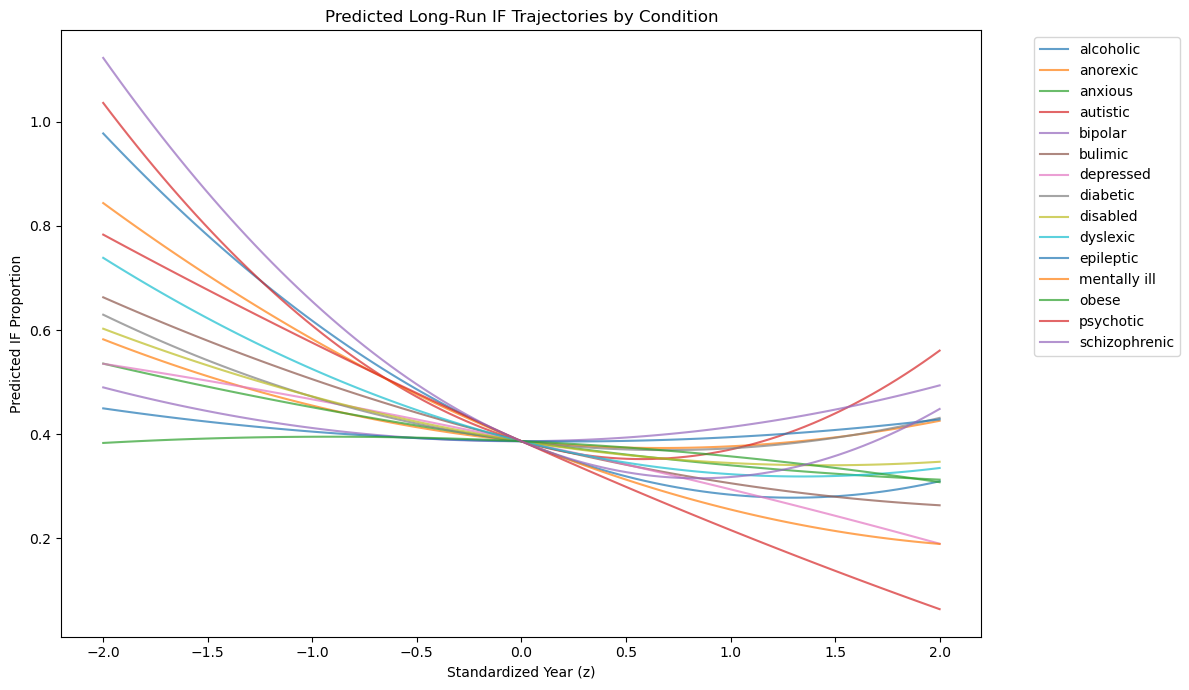

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load derived effects
df = pd.read_csv("output_GoogleBooks/mixed_effects_long_run/derived_effects_by_target.csv")

# Create standardized year vector (same scale as model)
year = np.linspace(-2, 2, 100)  # approx. standardized range

plt.figure(figsize=(12, 7))

for _, row in df.iterrows():
    pred = (row["intercept_plural"] 
            + row["slope_plural"] * year 
            + row["curvature_plural"] * year**2)
    plt.plot(year, pred, alpha=0.7, label=row["target"])

plt.xlabel("Standardized Year (z)")
plt.ylabel("Predicted IF Proportion")
plt.title("Predicted Long-Run IF Trajectories by Condition")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


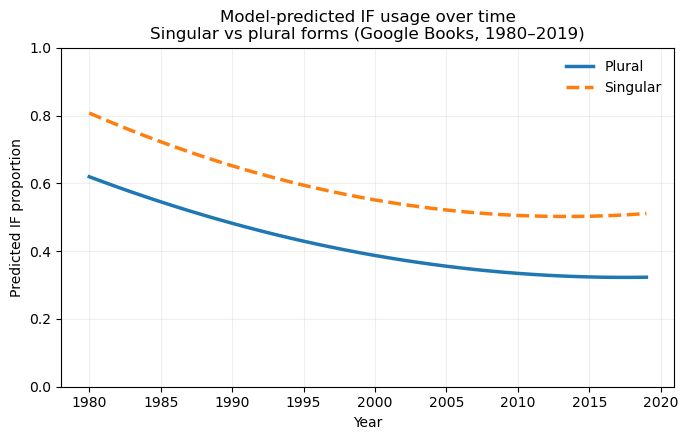

In [ ]:
# old model with interaction effect fpr number and year
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data to get mean/sd of Year for z-scoring
df = pd.read_csv("output_GoogleBooks/identity_first_proportion_by_target.csv")
year_mean = df["Year"].mean()
year_sd   = df["Year"].std(ddof=0)

# Fixed effects from mixed model
b_intercept   = 0.39090971415691766
b_number      = 0.16389261407904254        # singular vs plural (plural = reference)
b_year        = -0.08772859332500742
b_year2       = 0.02814883698128905
b_year2_num   = 0.008413002607676084       # Year^2 × number[T.singular]

# Year grid
years   = np.arange(1980, 2020)
year_z  = (years - year_mean) / year_sd
year_z2 = year_z**2

# Predicted IF proportion: plural (reference)
pred_plural = (
    b_intercept
    + b_year * year_z
    + b_year2 * year_z2
)

# Predicted IF proportion: singular
pred_singular = (
    b_intercept
    + b_number
    + b_year * year_z
    + (b_year2 + b_year2_num) * year_z2
)

# Plot
plt.figure(figsize=(7, 4.5))

plt.plot(years, pred_plural, label="Plural", linewidth=2.5)
plt.plot(years, pred_singular, label="Singular", linewidth=2.5, linestyle="--")

plt.xlabel("Year")
plt.ylabel("Predicted IF proportion")
plt.ylim(0, 1)
plt.title("Model-predicted IF usage over time\nSingular vs plural forms (Google Books, 1980–2019)")
plt.legend(frameon=False)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()


# End of script